In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin

### Logistic Regression Model

In [13]:
# Logistic regression
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class LogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.001, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            linear_pred = np.dot(X, self.weights) + self.bias
            predictions = sigmoid(linear_pred)

            dw = (1 / n_samples) * np.dot(X.T, (predictions - y))
            db = (1 / n_samples) * np.sum(predictions - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        linear_pred = np.dot(X, self.weights) + self.bias
        y_pred = sigmoid(linear_pred)
        class_pred = [0 if y <= 0.5 else 1 for y in y_pred]
        return class_pred


    def predict_proba(self, X):
        linear_pred = np.dot(X, self.weights) + self.bias
        y_prob = sigmoid(linear_pred)
        return np.column_stack((1 - y_prob, y_prob))

### Train 1

Training Error: 20.26%
Cross-Validation Errors: 21.50%
Test Error: 21.15%
Accuracy on the test dataset: 78.85%


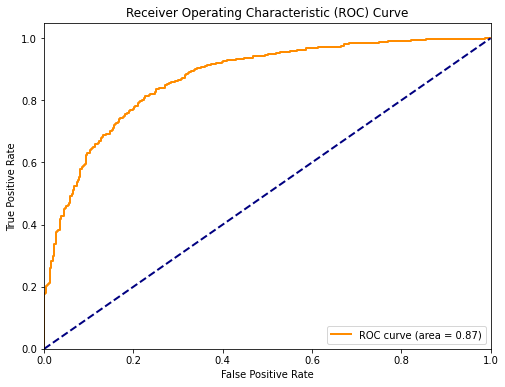

In [14]:
# Load the training dataset
icu_data = pd.read_csv("train1_icu_data.csv")
icu_labels = pd.read_csv("train1_icu_label.csv")

# Load the test dataset
icu_test_new = pd.read_csv("test1_icu_data.csv")
icu_testL_new = pd.read_csv("test1_icu_label.csv")

# Preprocess the training dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(icu_data)
y_train = icu_labels.values.ravel()

# Train a Logistic Regression classifier
clf = LogisticRegression(lr=0.5)
clf.fit(X_train, y_train)

# Function to calculate accuracy
def accuracy(y_pred, y_test):
    return np.sum(y_pred == y_test) / len(y_test)

# Calculate the training error
y_pred_train = clf.predict(X_train)
training_error = 1 - accuracy_score(y_train, y_pred_train)

# Calculate the cross-validation error
cross_val_errors = 1 - cross_val_score(clf, X_train, y_train, cv=5)

print("Training Error: {:.2f}%".format(training_error * 100))
print("Cross-Validation Errors: {:.2f}%".format(np.mean(cross_val_errors) * 100))

# Preprocess the test dataset
X_test_new = scaler.transform(icu_test_new)
y_test_new = icu_testL_new.values.ravel()

# Apply the trained classifier on TestSet-1
y_pred_new = clf.predict(X_test_new)

# Calculate the test error and accuracy
test_error = 1 - accuracy_score(y_test_new, y_pred_new)
print("Test Error: {:.2f}%".format(test_error * 100))
acc_new = accuracy(y_pred_new, y_test_new)
print("Accuracy on the test dataset: {:.2f}%".format(acc_new * 100))

# Calculate ROC curve and AUC
y_prob_new = clf.predict_proba(X_test_new)[:, 1]
fpr, tpr, _ = roc_curve(y_test_new, y_prob_new)
roc_auc = roc_auc_score(y_test_new, y_prob_new)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Optional Part

In [15]:
import statsmodels.api as sm
from prettytable import PrettyTable

# Create a list of feature names
feature_names = list(icu_data.columns)

# Fit the logistic regression model
X_train_const = sm.add_constant(X_train)
model = sm.Logit(y_train, X_train_const)
result = model.fit(maxiter=1000)  # Increase the number of iterations if needed

# Create a PrettyTable for displaying the summary
table = PrettyTable()
table.field_names = ["Feature", "Coefficient", "Odds Ratio", "P-Value", "95% CI (Lower)", "95% CI (Upper)"]

# Extract information from the model summary
params = result.params
conf_int = result.conf_int()
p_values = result.pvalues
odds_ratios = np.exp(params)

# Add rows to the PrettyTable
for feature, coef, odds_ratio, p_value, (ci_lower, ci_upper) in zip(feature_names, params, odds_ratios, p_values, conf_int):
    table.add_row([feature, round(coef, 4), round(odds_ratio, 4), round(p_value, 4), round(ci_lower, 4), round(ci_upper, 4)])

# Print the formatted table
print("Logistic Regression Summary")
print(table)


         Current function value: 0.429116
         Iterations: 1000
Logistic Regression Summary
+-------------------------------------------+-------------+------------+---------+----------------+----------------+
|                  Feature                  | Coefficient | Odds Ratio | P-Value | 95% CI (Lower) | 95% CI (Upper) |
+-------------------------------------------+-------------+------------+---------+----------------+----------------+
|                    age                    |    0.1941   |   1.2142   |   0.0   |     0.1153     |     0.2729     |
|                    bmi                    |    0.4098   |   1.5065   |   0.0   |     0.3446     |     0.475      |
|              elective_surgery             |    0.1946   |   1.2149   |  0.3551 |    -0.2179     |     0.6071     |
|                   height                  |   -0.1913   |   0.8259   |   0.0   |    -0.2801     |    -0.1025     |
|              pre_icu_los_days             |    0.0387   |   1.0395   |  0.7239 |   

C:\Users\soong\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Train 2

Training Error: 0.00%
Cross-Validation Errors: 1.42%
Test Error: 17.78%
Accuracy on the test dataset: 82.22%


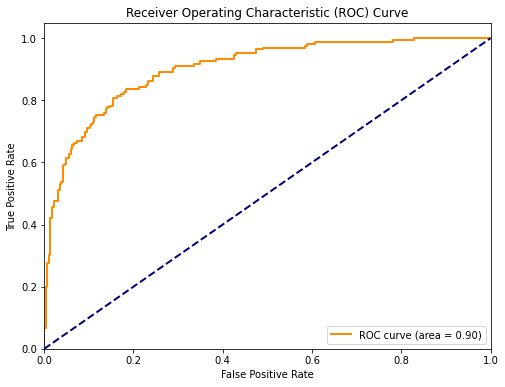

In [16]:
# Load the training dataset
icu_data = pd.read_csv("train2_icu_data.csv")
icu_labels = pd.read_csv("train2_icu_label.csv")

# Load the test dataset
icu_test_new = pd.read_csv("test2_icu_data.csv")
icu_testL_new = pd.read_csv("test2_icu_label.csv")

# Preprocess the training dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(icu_data)
y_train = icu_labels.values.ravel()

# Train a Logistic Regression classifier
clf = LogisticRegression(lr=0.5)
clf.fit(X_train, y_train)

# Function to calculate accuracy
def accuracy(y_pred, y_test):
    return np.sum(y_pred == y_test) / len(y_test)

# Calculate the training error
y_pred_train = clf.predict(X_train)
training_error = 1 - accuracy_score(y_train, y_pred_train)

# Calculate the cross-validation error
cross_val_errors = 1 - cross_val_score(clf, X_train, y_train, cv=5)

print("Training Error: {:.2f}%".format(training_error * 100))
print("Cross-Validation Errors: {:.2f}%".format(np.mean(cross_val_errors) * 100))

# Preprocess the test dataset
X_test_new = scaler.transform(icu_test_new)
y_test_new = icu_testL_new.values.ravel()

# Apply the trained classifier on TestSet-1
y_pred_new = clf.predict(X_test_new)

# Calculate the test error and accuracy
test_error = 1 - accuracy_score(y_test_new, y_pred_new)
print("Test Error: {:.2f}%".format(test_error * 100))
acc_new = accuracy(y_pred_new, y_test_new)
print("Accuracy on the test dataset: {:.2f}%".format(acc_new * 100))

# Calculate ROC curve and AUC
y_prob_new = clf.predict_proba(X_test_new)[:, 1]
fpr, tpr, _ = roc_curve(y_test_new, y_prob_new)
roc_auc = roc_auc_score(y_test_new, y_prob_new)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()